### Ideas to improve mAP

- Use Adelta optimizer instead of SGD https://www.koreascience.or.kr/article/JAKO201905653789024.pdf
- Find optimal learning rate for the optimizer https://www.jeremyjordan.me/nn-learning-rate/
- Paper that tests different methods https://arxiv.org/pdf/1812.01187.pdf
    - "By stacking cosine decay, label smoothing and mixup" (p. 7) - i'm trying this w/o mixup bc i dont understand it yet
    - label smoothing = 0.1 #don't use it doesn't work for us :(
    - torch LambdaLR with  cosine function from the paper
    - mixup https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py (the paper refs this paper)

### Importing and Dataset Initialisation

In [1]:
from fasterrcnn_train import create_train_test_dataset
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch


In [2]:
from dataset import AdsDataset
from detect import detect, draw_text
from preprocess.boxes import load_symbols_annotation
from preprocess.descriptors import TextEmbedModel, load_annotation_json, SentimentPreProcessor, StrategiesPreProcessor, TopicsPreProcessor, SlogansPreProcessor, QAPreProcessor
from textblob import TextBlob

In [3]:
ads_dataset = AdsDataset("qa") #Change string to get the descriptor
train, test = create_train_test_dataset(ads_dataset, "qa")

### Running Model

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Load model
model = torch.load("outputs/cp_qa_roberta_tfasterrcnn_10ep.pth.tar")["model"]
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)

In [5]:
model.eval()

TextFasterRCNN(
  (faster_rcnn): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

### Detect

In [1]:
from detect import detect

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Userr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
detect(["detect_input/joTest.jpg"],  "death", "sentiments", "0", False)

Time Taken: 10.213886976242065
Length of outputs is 19
Writing joTest.jpg to file...
Image 1: joTest.jpg done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [4]:
detect(["detect_input/joTest2.jpg"],  "death", "sentiments", "0", False)

Time Taken: 0.8590161800384521
Writing joTest2.jpg to file...
Image 1: joTest2.jpg done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [12]:
detect(["detect_input/joTest2.jpg"],  "I should not text and drive because I could die", "qa", "0", False)

Time Taken: 0.6650376319885254
Writing joTest2.jpg to file...
Image 1: joTest2.jpg done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [26]:
detect(["detect_input/joTest3.png"],  "I should use condoms because it is safe", "qa", "0.105", False)

Time Taken: 0.6645498275756836
Writing joTest3.png to file...
Image 1: joTest3.png done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


### Extracting Adjectives for QA

In [1]:
import nltk

In [2]:
lst =  ["I should buy this product because it's 40% off and it's fashionable.", "I should buy this product because it is fun and youthful", "I should buy American Eagle because I will be happy."]
for sentence in lst:
    parsed = nltk.pos_tag(nltk.word_tokenize(sentence))
    res = [elem for elem in parsed if elem[1] == "JJ"] #change to [:2] = JJ / [:2] == NN for nouns
    print(parsed)

[('I', 'PRP'), ('should', 'MD'), ('buy', 'VB'), ('this', 'DT'), ('product', 'NN'), ('because', 'IN'), ('it', 'PRP'), ("'s", 'VBZ'), ('40', 'CD'), ('%', 'NN'), ('off', 'IN'), ('and', 'CC'), ('it', 'PRP'), ("'s", 'VBZ'), ('fashionable', 'JJ'), ('.', '.')]
[('I', 'PRP'), ('should', 'MD'), ('buy', 'VB'), ('this', 'DT'), ('product', 'NN'), ('because', 'IN'), ('it', 'PRP'), ('is', 'VBZ'), ('fun', 'JJ'), ('and', 'CC'), ('youthful', 'JJ')]
[('I', 'PRP'), ('should', 'MD'), ('buy', 'VB'), ('American', 'NNP'), ('Eagle', 'NNP'), ('because', 'IN'), ('I', 'PRP'), ('will', 'MD'), ('be', 'VB'), ('happy', 'JJ'), ('.', '.')]


### QA Model Stop Words Testing

In [5]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Userr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [17]:
example_sent = "I should buy this product because it is fun and youthful"

stop_words = set(stopwords.words('english'))

stop_words.add("product")

word_tokens = word_tokenize(example_sent)

tagged_word_tokens = nltk.pos_tag(word_tokens)

#filtered_sentence = [w[0] for w in tagged_word_tokens if not w[0].lower() in stop_words and w[1][:2] == "JJ"]

filtered_sentence = []

for w in tagged_word_tokens:
	if w[0] not in stop_words and (w[1][:2] == "JJ" or w[1][:2] == "NN"):
		filtered_sentence.append(w[0])

print(word_tokens)
print(filtered_sentence)


['I', 'should', 'buy', 'this', 'product', 'because', 'it', 'is', 'fun', 'and', 'youthful']
['fun', 'youthful']


### Context Aware Sentence Embeddings

In [1]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/average_word_embeddings_glove.6B.300d')
embeddings = model.encode(sentences)
print(embeddings)

Downloading: 100%|██████████| 4.61M/4.61M [00:11<00:00, 391kB/s] 
Downloading: 100%|██████████| 190/190 [00:00<00:00, 184kB/s]
Downloading: 100%|██████████| 2.15k/2.15k [00:00<00:00, 2.15MB/s]
Downloading: 100%|██████████| 248/248 [00:00<00:00, 238kB/s]


[[-2.64665008e-01 -2.26674005e-01 -3.47996980e-01 -2.62654990e-01
   1.97190508e-01 -9.14949998e-02  2.47254997e-01 -4.24465001e-01
  -2.78364986e-01 -1.52365005e+00  1.21467993e-01  1.36302505e-02
  -3.94914985e-01  1.76838502e-01 -3.47050056e-02 -2.98945010e-01
  -1.14455998e-01 -2.27650031e-02 -1.51705846e-01 -4.99460012e-01
   1.65081993e-01 -1.47114992e-01  1.13208249e-01  2.10548490e-01
  -1.52712509e-01 -3.78019989e-01  4.16520014e-02 -3.06959987e-01
  -1.23482503e-01 -2.67659992e-01 -3.69657487e-01  5.36225021e-01
  -4.02254999e-01  1.31069988e-01 -7.51799941e-02 -2.85070002e-01
  -1.03549957e-02 -4.88460004e-01 -3.78574997e-01  2.42608503e-01
   4.61874485e-01  3.69210020e-02 -3.33090007e-01  1.46139994e-01
  -1.51894510e-01 -1.09146953e-01 -4.75178987e-01  5.64700007e-01
   3.96899953e-02 -6.06149994e-02 -2.58730024e-01 -1.20144993e-01
   2.95935005e-01  2.06270009e-01  1.00895002e-01 -1.57559980e-02
  -1.20039999e-01 -3.19000006e-01  1.16341501e-01 -1.28049999e-02
   5.83079

In [27]:
#save model to a file in directory, look at descriptors SentenceEmbedModel to see what I did
model.save("./testSave")

In [2]:
#embeddings = model.encode(sentences)
print(len(embeddings))

2


In [24]:
model.encode("Wonder Woman is gender transformative")

array([-9.41374898e-02, -2.00204998e-01, -2.03927755e-01, -1.73813254e-01,
       -4.08210233e-02,  9.51259956e-02, -6.00514784e-02, -2.76796758e-01,
       -1.07202474e-02, -6.90227568e-01,  9.08112451e-02,  1.65187508e-01,
       -1.48761198e-01, -4.37655002e-02,  1.19177505e-01, -1.71916261e-01,
        2.76014000e-01, -2.85710007e-01, -1.53565004e-01,  9.27124918e-02,
       -3.55350040e-02,  4.04159993e-01, -2.44080752e-01,  1.59776241e-01,
       -5.92642426e-02,  2.35174999e-01,  6.94392622e-02, -1.71130002e-01,
        3.90718788e-01,  2.12295994e-01, -5.49149923e-02,  6.52915016e-02,
       -2.37583011e-01, -2.67986745e-01, -5.29957533e-01,  3.70280027e-01,
       -1.20119244e-01,  1.48472503e-01,  9.03245062e-02,  1.09300748e-01,
        5.97152710e-01, -2.71880001e-01,  3.43824923e-03, -3.22356015e-01,
       -3.09404731e-01,  9.11167562e-02,  2.30930056e-02, -4.24074978e-02,
       -3.19848247e-02,  1.71765745e-01,  2.11399496e-01,  1.09480023e-02,
        2.66652524e-01, -

### BERT model experiments

In [13]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
Downloading:   4%|▍         | 198k/4.61M [05:11<1:55:51, 634B/s]
Downloading:   4%|▎         | 171k/4.61M [01:19<34:26, 2.15kB/s]


KeyboardInterrupt: 

In [4]:
classifier("We are very happy to show you the 🤗 Transformers library.")

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [34]:
from transformers import AutoTokenizer

In [35]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

KeyboardInterrupt: 

In [8]:
encoding = tokenizer("We are very happy to show you the 🤗 Transformers library.")
print(encoding)

{'input_ids': [101, 11312, 10320, 12495, 19308, 10114, 11391, 10855, 10103, 100, 58263, 13299, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
kfc = tokenizer("Finger Lickin  Good")

In [10]:
fbclass = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

Downloading: 100%|██████████| 1.13k/1.13k [00:00<00:00, 579kB/s]
Downloading: 100%|██████████| 1.52G/1.52G [01:41<00:00, 16.0MB/s]
Downloading: 100%|██████████| 26.0/26.0 [00:00<00:00, 6.50kB/s]
Downloading: 100%|██████████| 878k/878k [00:02<00:00, 380kB/s]  
Downloading: 100%|██████████| 446k/446k [00:01<00:00, 302kB/s]  
Downloading: 100%|██████████| 1.29M/1.29M [00:03<00:00, 435kB/s] 


In [14]:
sequence_to_classify = "bee spit never felt so good"
candidate_labels = ['restaurant', 'chocolate', 'chips', 'seasoning', 'petfood', 'alcohol', 'coffee', 'soda', 'cars', 
'electronics','phone_tv_internet_providers', 'financial', 'education', 'security', 'software', 'other_service', 'beauty', 'healthcare', 'clothing', 'baby', 'game',
'cleaning','home_improvement', 'home_appliance', 'travel', 'media', 'sports', 'shopping', 'gambling', 'environment', 'animal_right', 'human_right', 'safety', 'smoking_alcohol_abuse',
'domestic_violence', 'self_esteem', 'charities', 'political', 'unclear']
fbclass(sequence_to_classify, candidate_labels)["labels"][0]
#{'labels': ['travel', 'dancing', 'cooking'],
# 'scores': [0.9938651323318481, 0.0032737774308770895, 0.002861034357920289],
# 'sequence': 'one day I will see the world'}


'baby'

### Get weights list

In [ ]:
phrases = load_annotation_json() #loads the sentiments.json file
prep = SentimentPreProcessor() #loads a dictionary for indexing phrase  

data/annotations/Sentiments.json


In [ ]:
#https://gist.github.com/srikarplus/15d7263ae2c82e82fe194fc94321f34e
def make_weights_for_balanced_classes(image_ind, image_path, nclasses=30):
    phrases = load_annotation_json() #loads the sentiments.json file
    prep = SentimentPreProcessor() #loads a dictionary for indexing phrase   
    N = len(image_ind) #no of elems in the image_ind                                         
    weight = [0] * len(image_path)                                        
    for id, idx in enumerate(image_ind): 
        file = image_path[idx] 
        phrase_id = int(phrases[file][0][0])
        phrase = prep.id_to_word[phrase_id]
        count = classes[phrase]                                     
        weight[id] = count/N      
    samples_weight = [weight[t] for t in image_ind]        
    return samples_weight

In [ ]:
file = train.dataset.image_path[6424] 
phrase_id = int(phrases[file][0][0])
phrase = prep.id_to_word[phrase_id]
count = classes[phrase]     
print(count)

615


In [ ]:
file_writer = open("training_weights.txt", "w+")
weights = make_weights_for_balanced_classes(train.indices, train.dataset.image_path)
str_weights = ",".join(weights)
file_writer.write(str_weights)
file_writer.close()

data/annotations/Sentiments.json


In [ ]:
len(train.indices)

8499

In [ ]:
read_weights = open("training_weights.txt", "r")
read_string = read_weights.read()
weight_lst = [float(x) for x in read_string.split(",")]

In [ ]:
train_weights = weight_lst
train_weights = torch.DoubleTensor(train_weights)
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, len(train_weights))

### Plot Class Distribution

In [ ]:
classes ={}

In [ ]:
ds = train.dataset.image_path
for i in train.indices:
    file = ds[i]
    phrase_id = int(phrases[file][0][0])
    phrase = prep.id_to_word[phrase_id]
    try:
        check = classes[phrase]
    except:
        classes[phrase] = 0
    classes[phrase] += 1
        


In [ ]:
D = classes.keys()

In [ ]:
len(D)

30

In [ ]:
new_dict = {}
for c in list(D):
    new_dict[c] = 0

In [ ]:
total = 0
for i in list(D.values()):
    total += i
print(total)

8499


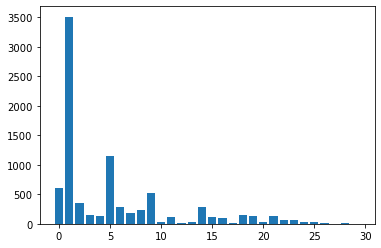

In [ ]:
plt.bar(range(len(D)), list(D.values()), align='center')
#plt.xticks(range(len(D)), list(D.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

In [ ]:
len(train)

8499

### IOU Stats from Model

In [5]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [6]:
def similarity_score(model, truth, pred):
    best_score = 0
    try:
        sim_scores = []
        truths = truth.split("/")
        pred_vec = model.get_vector_rep(pred.strip())
        for t in truths:
            true_vec = model.get_vector_rep(t.strip())
            sim_scores.append(cosine_sim(true_vec, pred_vec))
        best_score = max(sim_scores)
    except:
        pass
    return best_score, (best_score>=0.1)

In [7]:
def get_top3_preds(preds):
    if len(preds) <= 3:
        return preds
    else:
        preds.sort(key=lambda x:x[5], reverse=True)
        return preds[:3]

In [8]:
one = [0,0,0,0,0,10]
two = [1,1,1,1,1,5]
three = [1,1,1,2,2,11]
four = [-1,-1,-1,-1,-1,22]
lst = [one, two, three, four]
get_top3_preds(lst)

[[-1, -1, -1, -1, -1, 22], [1, 1, 1, 2, 2, 11], [0, 0, 0, 0, 0, 10]]

In [8]:
#%%Get total iou, precision, recall
#https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

def write_stats(df, true, pred, filename):
    df = pd.DataFrame(df)

    #Define list for each column in df
    predlabels, truelabels, ious, corrects, filenames,\
        conf_score, confidence, label_similarity, sames= [], [], [], [], [], [], [], [], []

    #Load TextEmbedModel
    similarity_model = TextEmbedModel()
    
    #For every ground truth, compare with every prediction
    for t in true:
        filenames.append(filename)
        loc_max_iou = 0
        loc_max_label = None
        loc_max_score = 0
        #to get prediction that maximises IOU with ground truth t
        for p in pred:
            iou = bb_intersection_over_union(p[:4], t[:4])
            if iou >= loc_max_iou:
                loc_max_iou = iou
                loc_max_label = p[4]
                loc_max_score = p[5]
        
        sim_score, same = similarity_score(similarity_model, t[4], loc_max_label)

        #add correct info to the files
        ious.append(loc_max_iou)
        corrects.append(loc_max_iou>=0.5)
        predlabels.append(loc_max_label)
        truelabels.append(t[4])
        conf_score.append(loc_max_score)
        confidence.append(loc_max_score>=0.1)
        label_similarity.append(sim_score)
        sames.append(same)

    #Make dataframe from the values above, append to dataframe
    df2 = pd.DataFrame({
                "filename":filenames,
                "iou": ious,
                "correct?" : corrects,
                "pred labels": predlabels,
                "true labels": truelabels,
                "class confidence": conf_score,
                "confident?":confidence,
                "similarity":label_similarity,
                "label same?":sames})
    df = df.append(df2, ignore_index=True)
    #Save Data to CSV
    return df

In [9]:
#%%Get average 3 iou, precision, recall
#https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

def write_stats_avg3(df, true, pred, filename):
    df = pd.DataFrame(df)

    #Define list for each column in df
    filenames, prec, recall, f1 = [], [], [], []

    #Load TextEmbedModel
    similarity_model = TextEmbedModel()
    
    #For every ground truth, compare with every prediction
    for t in true:
        filenames.append(filename)
        #to get prediction that maximises IOU with ground truth t
        pred3 = get_top3_preds(pred)
        tp = 0
        fp = 0
        fn = len(pred3)
        for p in pred3:
            iou = bb_intersection_over_union(p[:4], t[:4])
            sim_score, same = similarity_score(similarity_model, t[4], p[4])
            correct = iou >= 0.5
            confident = p[5] >= 0.1
            tp += int(correct and confident and same)
            fp += int(confident and (not correct or not same))
            fn -= int(not confident)
        
        avg_prec = (tp//(tp+fp))/len(pred3)
        avg_recall = (tp//(tp+fn))/len(pred3)
        avg_f1 = ((2*(tp*fp))//(tp+fp))/len(pred3)
        #new
        prec.append(avg_prec)
        recall.append(avg_recall)
        f1.append(avg_f1)


    #Make dataframe from the values above, append to dataframe
    df2 = pd.DataFrame({
                "filename":filenames,
                "avg_precision":prec,
                "avg_recall":recall,
                "avg_f1":f1})
    df = df.append(df2, ignore_index=True)

    #Save Data to CSV
    return df

In [10]:
#Factory Method for Data, Preprocessor
def prep_factory(descriptor="sentiments"):
    data = load_symbols_annotation() #loads the symbols.json file
    if descriptor == "sentiments":
        phrases = load_annotation_json() #loads the sentiments.json file
        prep = SentimentPreProcessor() #loads a dictionary for indexing phrase
    elif descriptor == "strategies":
        phrases = load_annotation_json("data/annotations/Strategies.json") #loads the strategies.json file
        prep = StrategiesPreProcessor() #loads a dictionary for indexing phrase
    elif descriptor == "topics":
        phrases = load_symbols_annotation("data/annotations/Topics.json") #loads the symbols.json file
        prep = TopicsPreProcessor() #loads a dictionary for indexing phrase
    elif descriptor == "slogans":
        phrases = load_symbols_annotation("data/annotations/Slogans.json") #loads the symbols.json file
        prep = SlogansPreProcessor() #loads a dictionary for indexing phrase
    elif descriptor == "qa":
        phrases = load_symbols_annotation("data/annotations/QA_Combined_Action_Reason.json") #loads the symbols.json file
        prep = QAPreProcessor() #loads a dictionary for indexing phrase
    print("loaded")
    return data, phrases, prep

In [11]:
# %% get the annotations for said files.
def testing(files,res_file=None, descriptor = "sentiments"):
   #load relevant files
   data, phrases, prep = prep_factory(descriptor)
   if res_file != None:
      df = pd.read_csv(res_file, index_col = None)

   #get phrase, truth, and predicted bbox for each file
   i = 0
   for file in files:
      if (i%100)==0 and i!=0:
         print("100 Done")
      
      try:
         #preprocess data for write_stats function
         if descriptor == "slogans" or descriptor == "qa":
            phrase = phrases[file][0]
         else:
            lst = [int(x[0]) for x in phrases[file]]
            phrase = prep.id_to_word[max(lst, key=lst.count)]
            #phrase_id = int(phrases[file][0][0])
            #phrase = prep.id_to_word[most_common_descriptor]
         filepath = "data/" + file
         #bounding box and label of the objects (symbols) in that image
         preds = detect([filepath],  phrase, descriptor, "0", True)
         #print(i)
         print(preds)
         #bounding box and label of the symbols in that image
         truth = data[file]
         #get stats
         df = write_stats(df, truth, preds, file)
         i += 1
      except:
         i += 1
         next

      
      if(i%20)==0:
         torch.cuda.empty_cache()
   
   #Read results to csv
   if res_file != None:
      df.to_csv(res_file, index=False)
   return "DONE"



In [12]:
torch.cuda.empty_cache() #run to clear CUDA memory

In [13]:
test_files = []
ds = test.dataset.image_path

In [14]:
for i in test.indices:
    test_files.append(ds[i])

In [15]:
len(test_files)

776

### General Testing

In [16]:
testing(test_files, res_file= "qa_10ep_newrob.csv", descriptor="qa")

loaded
[0.3932223  0.21161091 0.20609203 0.1847437  0.17638426 0.16783816
 0.15185143 0.15070546 0.14481656 0.13649541 0.12984362 0.11819461
 0.08975994 0.08465483 0.08226553 0.08134973 0.07587792 0.07569654
 0.07249591 0.06681574 0.06576225 0.0652364  0.06477487 0.06432535
 0.06272985 0.06226984 0.06046117 0.06004977 0.05815306 0.05728941
 0.05534121 0.05468391 0.05412715 0.05346901 0.05315819 0.05297816
 0.05094627 0.05076934]
[[81, 75, 117, 145, 'Plenty/Healthy', 0.3932223], [65, 72, 183, 189, 'Plenty/Healthy', 0.21161091], [62, 20, 153, 212, 'Plenty/Healthy', 0.20609203], [71, 86, 135, 123, 'Plenty/Healthy', 0.1847437], [68, 9, 230, 246, 'Plenty/Healthy', 0.17638426], [85, 91, 116, 125, 'Plenty/Healthy', 0.16783816], [40, 43, 282, 197, 'Plenty/Healthy', 0.15185143], [70, 76, 255, 145, 'Plenty/Healthy', 0.15070546], [68, 67, 104, 148, 'Plenty/Healthy', 0.14481656], [112, 76, 236, 193, 'Plenty/Healthy', 0.13649541], [124, 0, 281, 246, 'Plenty/Healthy', 0.12984362], [85, 151, 162, 189

'DONE'

In [14]:
import pickle

In [15]:
le = pickle.loads(open("outputs/le.pickle", "rb").read())
CLASSES = le.classes_

In [17]:
le

LabelEncoder()

### Word Similarity

In [17]:
from preprocess.descriptors import TextEmbedModel, cosine_sim, SentenceEmbedModel

In [ ]:
from gensim.models import KeyedVectors

In [18]:
vecModel = SentenceEmbedModel("stsb-roberta-base")

In [ ]:
vec1 = vecModel.get_vector_rep("bathing suit")
vec2 = vecModel.get_vector_rep("style")

In [ ]:
cosine_sim(vec1, vec2)

0.17391120245809366

In [19]:
import pandas as pd

In [20]:
usableModel  = KeyedVectors.load("glove-wiki-gigaword-300.model")

NameError: name 'KeyedVectors' is not defined

In [21]:
df = pd.read_csv("qa_10ep_newrob.csv", index_col=None, keep_default_na=False)
df.head()

,filename,iou,correct?,pred labels,true labels,class confidence,confident?,similarity,label same?
0,10/173561.png,0.238868,False,Plenty/Healthy,art/painting/beauty,0.075697,False,0,False
1,10/173561.png,0.498974,False,Plenty/Healthy,Beauty,0.129844,True,0,False
2,10/173561.png,0.305728,False,Plenty/Healthy,Classic,0.129844,True,0,False
3,10/170267.png,0.000000,False,,homemade,0.000000,False,0,False
4,10/172538.png,0.000000,False,Armor,Military/Service,0.055285,False,0,False


In [22]:
df["label same?"] = False
df["similarity"] = float(0)

In [23]:
for i, row in df.iterrows():
    truths = row["true labels"].split("/")
    pred = row["pred labels"].strip()
    try:
        scores = []
        for truth in truths:
            v1 = vecModel.get_vector_rep(truth)
            v2 = vecModel.get_vector_rep(pred)
            s = cosine_sim(v1, v2)
            #s = usableModel.similarity(truth, pred)
            scores.append(s)
        df.at[i, "similarity"] = max(scores)
    except:
        pass
df["label same?"] = df["similarity"] >= 0.1
    

In [24]:
df[df["label same?"]==True].head()

,filename,iou,correct?,pred labels,true labels,class confidence,confident?,similarity,label same?
0,10/173561.png,0.238868,False,Plenty/Healthy,art/painting/beauty,0.075697,False,0.248573,True
1,10/173561.png,0.498974,False,Plenty/Healthy,Beauty,0.129844,True,0.248573,True
2,10/173561.png,0.305728,False,Plenty/Healthy,Classic,0.129844,True,0.135559,True
3,10/170267.png,0.000000,False,,homemade,0.000000,False,0.299719,True
4,10/172538.png,0.000000,False,Armor,Military/Service,0.055285,False,0.729175,True


In [22]:
df[df["label same?"]==True].head()

,filename,iou,correct?,pred labels,true labels,class confidence,confident?,similarity,label same?
0,10/173561.png,0.262004,False,Plenty/Healthy,art/painting/beauty,0.219626,True,0.248573,True
1,10/173561.png,0.431617,False,Plenty/Healthy,Beauty,0.097413,False,0.248573,True
2,10/173561.png,0.344267,False,Plenty/Healthy,Classic,0.097413,False,0.135559,True
3,10/170267.png,0.000000,False,,homemade,0.000000,False,0.299719,True
4,10/172538.png,0.000000,False,,Military/Service,0.000000,False,0.526692,True


In [20]:
df[df["label same?"]==True].head()

,filename,iou,correct?,pred labels,true labels,class confidence,confident?,similarity,label same?
0,10/173561.png,0.262004,False,Plenty/Healthy,art/painting/beauty,0.219626,True,0.248573,True
1,10/173561.png,0.431617,False,Plenty/Healthy,Beauty,0.097413,False,0.248573,True
2,10/173561.png,0.344267,False,Plenty/Healthy,Classic,0.097413,False,0.135559,True
3,10/173561.png,0.262004,False,Plenty/Healthy,art/painting/beauty,0.219626,True,0.248573,True
4,10/173561.png,0.431617,False,Plenty/Healthy,Beauty,0.097413,False,0.248573,True


In [8]:
df.head()

,filename,iou,correct?,pred labels,true labels,class confidence,confident?,similarity,label same?
0,10/173561.png,0.254697,False,torn,art/painting/beauty,0.105494,True,0.350673,True
1,10/173561.png,0.426474,False,torn,Beauty,0.063683,False,0.160555,True
2,10/173561.png,0.301362,False,torn,Classic,0.063683,False,0.239239,True
3,10/170267.png,0.000000,False,,homemade,0.000000,False,0.189801,True
4,10/172538.png,0.126021,False,events,Military/Service,0.053459,False,0.170644,True


In [25]:
df.to_csv("qa_10ep_newrob.csv")

### Plot boxes over image

### Playground, No Need to Run

In [9]:
test_files[7]

'10/175362.png'

In [19]:
testing(['10/175362.png'])

loaded
Time Taken: 0.8173787593841553
[[187, 24, 371, 429, 'fun', 0.060499992], [80, 98, 389, 294, 'fun', 0.051590566]]


'DONE'

In [20]:
data, phrase, prep = prep_factory("qa")

loaded


In [21]:
phrase['10/175362.png']

['I should it Post sugar cereal because those bears look like fun.',
 'I should buy Post Sugar Crisp because it tastes good.',
 'I should buy Post Sugar Crisp because they are fun and tasty with fruit']

In [23]:
data['10/175362.png']

[[33.0, 113.0, 181.0, 320.0, 'Fresh/Natural'],
 [2.0, 94.0, 499.0, 476.0, 'Fun/Industrialism'],
 [354.0, 280.0, 500.0, 475.0, 'fun/mischievousness '],
 [38.0, 20.0, 478.0, 337.0, 'Loaded'],
 [0.0, 305.0, 243.0, 117.0, 'working']]

In [ ]:
testing(['2/19752.jpg'], "original")

data/annotations/Sentiments.json
TEST PREDICTIONS COMPLETE
[[71, 89, 580, 461, 'natural', 0.07402506]]
[[409.0, 309.0, 104.0, 67.0, 'Humor'], [104.0, 80.0, 399.0, 273.0, 'soothing'], [55.0, 220.0, 199.0, 353.0, 'Nature'], [54.0, 249.0, 398.0, 352.0, 'natural honey'], [76.0, 65.0, 414.0, 298.0, 'natural']]


'DONE'

In [28]:
pred =[[187, 24, 371, 429, 'fun', 0.060499992], [80, 98, 389, 294, 'fun', 0.051590566]]
truth = [[409.0, 309.0, 104.0, 67.0, 'Humor'], [104.0, 80.0, 399.0, 273.0, 'soothing'], [55.0, 220.0, 199.0, 353.0, 'Nature'], [54.0, 249.0, 398.0, 352.0, 'natural honey'], [76.0, 65.0, 414.0, 298.0, 'natural']]

In [ ]:
#get the third file from Symbol.json
data = load_symbols_annotation()
data[files[2]]

[[317.0, 479.0, 6.0, 168.0, 'Promiscuity '],
 [93.0, 355.0, 230.0, 474.0, 'sexual promiscuity '],
 [80.0, 335.0, 240.0, 479.0, 'well traveled'],
 [106.0, 347.0, 228.0, 491.0, 'use condoms']]

In [ ]:
data[files[0]]

[[124.0, 251.0, 372.0, 463.0, 'irony/comedy'],
 [392.0, 468.0, 140.0, 139.0, 'entertainment']]

In [ ]:
bbox1_original =[[55, 54, 236, 357, 'sex', 0.12237799], [42, 22, 249, 335, 'beauty', 0.11320336], 
[89, 205, 220, 344, 'violence', 0.0742097], [60, 47, 216, 176, 'violence', 0.0688863], [52, 83, 259, 348, 'violence', 0.064791024], 
[34, 17, 253, 329, 'sexy', 0.056233153], [49, 40, 219, 194, 'sex', 0.056071434], [57, 213, 247, 345, 'sex', 0.055351675], 
[40, 17, 227, 175, 'beauty', 0.053884428], [79, 140, 209, 349, 'sex', 0.053622432]]

bbox1_sentiment = [[71, 221, 249, 327, 'violence', 0.120133504], [61, 78, 235, 337, 'violence', 0.09435376], 
[54, 78, 246, 339, 'sex', 0.092009455], [100, 171, 220, 345, 'violence', 0.088896535], [101, 250, 207, 343, 'violence', 0.0727949], 
[2, 19, 308, 353, 'sex', 0.05925332], [66, 47, 212, 192, 'violence', 0.056183454], [31, 35, 248, 254, 'violence', 0.052093174]]

bbox2 = [[317.0, 479.0, 6.0, 168.0, 'Promiscuity '],
 [93.0, 355.0, 230.0, 474.0, 'sexual promiscuity '],
 [80.0, 335.0, 240.0, 479.0, 'well traveled'],
 [106.0, 347.0, 228.0, 491.0, 'use condoms']]

In [ ]:
bb_intersection_over_union(bbox2[0][:4], bbox1_sentiment[7][:4])

0

In [ ]:
print(bbox2[0][:2])
print(bbox2[0][2:4])
print(abs(bbox2[0][0]-bbox2[0][2])) #width
print(abs(bbox2[0][1]-bbox2[0][3])) #height
311*311

[317.0, 479.0]
[6.0, 168.0]
311.0
311.0


96721

In [ ]:
bbox1_sentiment

[[71, 221, 249, 327, 'violence', 0.120133504],
 [61, 78, 235, 337, 'violence', 0.09435376],
 [54, 78, 246, 339, 'sex', 0.092009455],
 [100, 171, 220, 345, 'violence', 0.088896535],
 [101, 250, 207, 343, 'violence', 0.0727949],
 [2, 19, 308, 353, 'sex', 0.05925332],
 [66, 47, 212, 192, 'violence', 0.056183454],
 [31, 35, 248, 254, 'violence', 0.052093174]]

In [ ]:
bb_intersection_over_union(bbox1_sentiment[0][:4], bbox2[0][:4])

0.19507656041604202

In [32]:
def draw_bboxes(true, pred, filename):
    """
    true: truths from Symbols.json
    pred: predicted values from model
    """
    # bg_img = np.zeros([512,512,3],dtype=np.uint8)
    # bg_img.fill(255)
    img = cv2.imread("data/"+filename)[:,:,::-1]                      # Read image
    bg_img = cv2.resize(img, (512, 512))
    for p in pred:
        cv2.rectangle(
                    bg_img,
                    (int(p[0]), int(p[1])),
                    (int(p[2]), int(p[3])),
                    (255,0,0),
                    2,)
        draw_text(
                        img=bg_img,
                        text=p[4] + " " + str(p[5]),
                        pos=(int(p[0]), int(p[1])),
                        text_color_bg=(255,0,0),
                        text_color = (0,0,0)
                    )

    for t in true:
        cv2.rectangle(
                bg_img,
                (int(t[0]), int(t[3])),
                (int(t[2]), int(t[1])),
                (0,255,0),
                2,)
        draw_text(
                        img=bg_img,
                        text=t[4],
                        pos=(int(t[0]), int(t[1])),
                        text_color_bg=(0,255,0),
                        text_color = (0,0,0)
                    )
    
    return bg_img

In [ ]:
get_total_iou(bbox2, bbox1_sentiment, "sentiment")
get_total_iou(bbox2, bbox1_original, "original")

'DONE'

In [ ]:
phrases = load_annotation_json()

data/annotations/Sentiments.json


In [ ]:
phrases['10/171489.png']

[['12'], ['19'], ['3', '4']]

In [ ]:
pred

[[81, 81, 529, 467, 'natural', 0.055871446]]

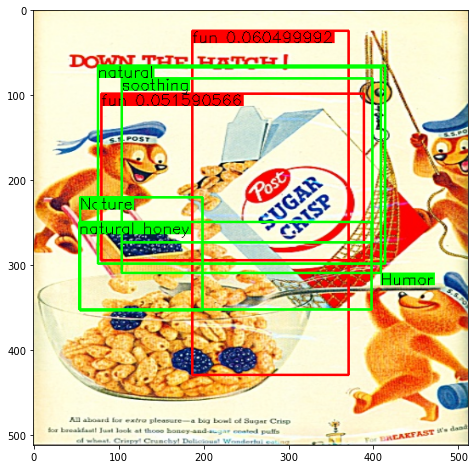

In [33]:
img = draw_bboxes(truth, pred, '10/175362.png')
plt.figure(figsize = (8,8))
plt.imshow(img)

In [ ]:
img = draw_bboxes(truth, pred, '10/175181.png')
plt.figure(figsize = (8,8))
plt.imshow(img)

In [ ]:
pred_o = [[71, 89, 580, 461, 'natural', 0.07402506]]
truth_o = [[409.0, 309.0, 104.0, 67.0, 'Humor'], [104.0, 80.0, 399.0, 273.0, 'soothing'], [55.0, 220.0, 199.0, 353.0, 'Nature'], [54.0, 249.0, 398.0, 352.0, 'natural honey'], [76.0, 65.0, 414.0, 298.0, 'natural']]

In [6]:
pred_o = [[405.0, 303.0, 103.0, 65.0, 'Nature', 0.7402506]]
truth_o = [[409.0, 309.0, 104.0, 67.0, 'Humor']]

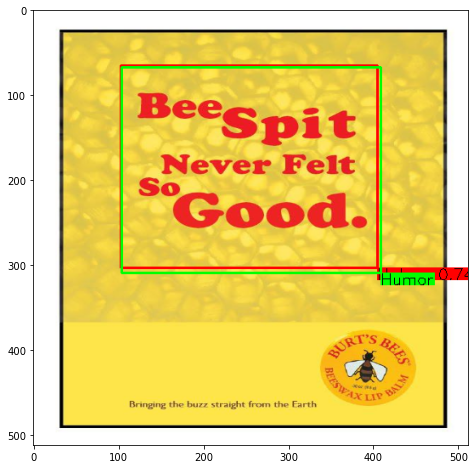

In [7]:
img = draw_bboxes(truth_o, pred_o, '2/19752.jpg')
plt.figure(figsize = (8,8))
plt.imshow(img)

In [ ]:
files[2]

'10/171489.png'

In [ ]:
bbox2

[[317.0, 479.0, 6.0, 168.0, 'Promiscuity '],
 [93.0, 355.0, 230.0, 474.0, 'sexual promiscuity '],
 [80.0, 335.0, 240.0, 479.0, 'well traveled'],
 [106.0, 347.0, 228.0, 491.0, 'use condoms']]

### Misc

In [ ]:
import torch
from torch import nn

In [ ]:

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
#output = triplet_loss(anchor, positive, negative)

In [ ]:
chec = anchor[:10]

In [ ]:
chec.size()

torch.Size([10, 128])

In [ ]:
import math

In [ ]:
import matplotlib as plt

In [ ]:
[((((1 + math.cos(x * math.pi / 10)) / 2) ** 1.0) * 0.9 + 0.1) for x in range(1,10)]

[0.9779754323328191,
 0.9140576474687263,
 0.8145033635316129,
 0.6890576474687263,
 0.55,
 0.41094235253127376,
 0.2854966364683872,
 0.18594235253127372,
 0.12202456766718092]

In [ ]:
lf = lambda x: (((1 + math.cos(x * math.pi / x)) / 2) ** 1.0) * 0.9 + 0.1  # cosine

In [1]:
from preprocess import descriptors as desc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Userr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [5]:
import torch

In [12]:
text_embed = desc.TextEmbedModel()
phrase_embed = text_embed.get_vector_rep("swimsuit")
phrase_embed = torch.from_numpy(phrase_embed).float()
#print(phrase_embed)
# phrase_embed = [torch.from_numpy(phrase_embed).float()]
# print(phrase_embed)

In [13]:
descriptors = phrase_embed

In [17]:

batch_size = descriptors.size()[0]
num_anchors_boxes = 2 // batch_size

# Append the descriptor text appending to the fully connected layer.
b = []
for i in range(descriptors.size()[0]):
    t = torch.unsqueeze(descriptors[i], 0)
    print(t)
    # t = t.expand(num_anchors_boxes, descriptors.size()[1])
    # b.append(t)
d = torch.cat(b, dim=0)

tensor([0.3443])
tensor([-0.0173])
tensor([-0.0321])
tensor([-0.3394])
tensor([-0.3674])
tensor([0.3709])
tensor([-0.5304])
tensor([-0.1314])
tensor([-0.2682])
tensor([0.1741])
tensor([0.1189])
tensor([-0.1630])
tensor([0.3314])
tensor([0.4030])
tensor([0.1115])
tensor([0.3983])
tensor([0.0608])
tensor([0.2232])
tensor([-0.2417])
tensor([-0.8319])
tensor([-0.4538])
tensor([0.6832])
tensor([-0.4693])
tensor([0.1915])
tensor([-0.0443])
tensor([-0.2948])
tensor([0.6416])
tensor([0.4065])
tensor([0.7386])
tensor([-0.3462])
tensor([0.6624])
tensor([-0.9129])
tensor([0.1729])
tensor([-0.1958])
tensor([-0.6309])
tensor([0.2611])
tensor([-0.4783])
tensor([0.2847])
tensor([0.2156])
tensor([0.1173])
tensor([0.6001])
tensor([-0.7010])
tensor([-0.3418])
tensor([0.1298])
tensor([-0.2802])
tensor([0.3022])
tensor([0.2401])
tensor([-0.2258])
tensor([0.0788])
tensor([0.3305])
tensor([0.1140])
tensor([-0.0489])
tensor([-0.6052])
tensor([-0.8189])
tensor([0.1074])
tensor([0.0252])
tensor([-0.3569])
tens

NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

CPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterCPU.cpp:21063 [kernel]
CUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterCUDA.cpp:29726 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterQuantizedCPU.cpp:1258 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradMLC: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse1: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse2: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse3: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\TraceType_3.cpp:11220 [kernel]
AutocastCPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:305 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:52 [backend fallback]


In [1]:
# feature extaction from pretrained model: https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
import torch
import torch.nn as nn
import torchvision.models as models
import utils
import torch.nn.functional as F
vse = nn.Sequential(
                nn.Linear(opts.imfeatDim + 300, opts.embDim),
                nn.BatchNorm1d(opts.embDim),
                nn.LeakyReLU(0.02, inplace=True),
            )

ModuleNotFoundError: No module named 'utils'

### Get All Files for Ranking 

In [1]:
import json

In [25]:
completed  = {}

In [3]:
from preprocess.descriptors import SentimentPreProcessor, StrategiesPreProcessor, TopicsPreProcessor

In [23]:
sentproc = SentimentPreProcessor()
stratproc = StrategiesPreProcessor()
topicproc = TopicsPreProcessor()

In [6]:
sloganfile = open("data/annotations/Slogans.json")
slogans = json.load(sloganfile)

In [2]:
sentimentfile = open("data/annotations/Sentiments.json")
sentiments = json.load(sentimentfile)

In [15]:
strategiesfile = open("data/annotations/Strategies.json")
strategies = json.load(strategiesfile)

In [4]:
topicsfile = open("data/annotations/Topics.json")
topics = json.load(topicsfile)

In [1]:
import json

In [2]:
qafile = open("data/annotations/QA_Combined_Action_Reason.json")
qas = json.load(qafile)

In [3]:
len(sentiments.keys())

30340

In [8]:
len(slogans.keys())

3710

In [12]:
list(slogans.keys())[0]

'10/170489.png'

In [26]:
for k in list(slogans.keys()):
    try:
        sentiment = sentiments[k]
        strategy = strategies[k]
        topic = topics[k]
        qa = qas[k]
        slogan = slogans[k]
    except KeyError:
        next
    else:
        completed[k] = {"Slogan":slogan, "Sentiment": sentiment, "Strategy": strategy, "Topic":topic, "QA": qa}

In [27]:
len(completed.keys())

3710

In [28]:
completed['10/170489.png']

{'Slogan': ['Endless fun with amazing taste. ',
  'Better get a butterfinger',
  'Butterfingers will make you cool like Bart Simpson.'],
 'Sentiment': [['6', '14'], ['12'], ['11']],
 'Strategy': [['5'], ['6'], ['2', '5'], ['2', '6', '8'], ['5', '6', '9']],
 'Topic': ['2', '2', '2'],
 'QA': ['I should buy a Butterfinger because it will make my life more fun. ',
  'I should eat butterfingers because the simpsoms say',
  'I should buy this product because it will make me as funny as Bart Simpson.']}

In [29]:
json_object = json.dumps(completed)
with open("compiled_descriptors.json", "w") as outfile:
    outfile.write(json_object)
outfile.close()

### RoBERTa

In [1]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Downloading: 100%|██████████| 878k/878k [00:16<00:00, 56.1kB/s] 
Downloading: 100%|██████████| 446k/446k [00:06<00:00, 70.6kB/s] 
Downloading: 100%|██████████| 481/481 [00:00<00:00, 124kB/s]
Downloading: 100%|██████████| 478M/478M [03:42<00:00, 2.26MB/s] 
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
text = "I should eat a butterfinger because it will make me funny like Bart Simpson."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0891,  0.1053, -0.0083,  ..., -0.0876, -0.0457, -0.0820],
         [ 0.1197,  0.1413,  0.0139,  ...,  0.4163, -0.0789, -0.1427],
         [ 0.2349,  0.1151,  0.0247,  ...,  0.1086, -0.1882,  0.0277],
         ...,
         [ 0.0378,  0.1295, -0.1772,  ...,  0.1043, -0.0233, -0.1807],
         [-0.0762,  0.0980, -0.0275,  ..., -0.1103, -0.0509, -0.1119],
         [-0.0160,  0.0246,  0.0718,  ...,  0.0901,  0.0069,  0.0089]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-6.9584e-03, -2.1812e-01, -2.1185e-01, -8.4745e-02,  1.4698e-01,
          2.4359e-01,  2.7229e-01, -4.7428e-02, -8.9845e-02, -1.7839e-01,
          2.7340e-01, -1.0108e-02, -1.1908e-01,  1.4431e-01, -1.5892e-01,
          4.8113e-01,  2.2214e-01, -5.2554e-01,  4.6611e-02, -2.7568e-02,
         -2.9038e-01,  5.7366e-02,  5.0207e-01,  3.3396e-01,  1.3451e-01,
          3.3720e-02, -1.7331e-01,  9.0274e-03,  1.7511e-01,  2.628

In [32]:
vec = np.zeros([768])

In [12]:
get_embed = model.get_input_embeddings()

In [22]:
get_embed(input=(encoded_input['input_ids'])).shape

torch.Size([1, 18, 768])

In [24]:
outputs = get_embed(input=(encoded_input['input_ids']))

In [33]:
check = outputs.flatten().tolist()

In [41]:
import torch

In [42]:
sentence = torch.tensor([tokenizer.encode(text)])
embedding_output = model.embeddings(sentence)

In [43]:
embedding_output == outputs

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [44]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/stsb-roberta-base')
embeddings = model.encode(sentences)
print(embeddings)


Downloading: 100%|██████████| 190/190 [00:00<00:00, 31.7kB/s]
Downloading: 100%|██████████| 3.92k/3.92k [00:00<00:00, 817kB/s]
Downloading: 100%|██████████| 122/122 [00:00<00:00, 40.7kB/s]
Downloading: 100%|██████████| 456k/456k [00:04<00:00, 100kB/s]  
Downloading: 100%|██████████| 229/229 [00:00<00:00, 32.8kB/s]
Downloading: 100%|██████████| 499M/499M [03:36<00:00, 2.30MB/s]   
Downloading: 100%|██████████| 52.0/52.0 [00:00<00:00, 8.68kB/s]
Downloading: 100%|██████████| 239/239 [00:00<00:00, 30.1kB/s]
Downloading: 100%|██████████| 1.36M/1.36M [00:12<00:00, 105kB/s] 
Downloading: 100%|██████████| 1.17k/1.17k [00:00<00:00, 232kB/s]
Downloading: 100%|██████████| 798k/798k [00:05<00:00, 150kB/s]  


[[ 0.22557165 -0.97884667 -0.03724959 ... -0.2209067  -0.00818081
   1.469829  ]
 [ 1.2658299  -0.0626128   0.25971535 ...  0.1752552   0.51256835
   1.1866349 ]]


In [45]:
len(embeddings[0])

768

In [46]:
bart = model.encode("I should eat butterfingers because they will make me funny like Bart Simpson.")

In [1]:
from detect import detect

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Userr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
import torch

In [19]:
torch.cuda.empty_cache()

In [18]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 4            |        cudaMalloc retries: 6         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    3512 MB |    3512 MB |   52822 MB |   49309 MB |\n|       from large pool |    3386 MB |    3386 MB |   52145 MB |   48759 MB |\n|       from small pool |     126 MB |     126 MB |     677 MB |     550 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    3512 MB |    3512 MB |   52822 MB |   49309 MB |\n|       from large pool |    3386 MB |    3386 MB |

In [6]:
detect(["detect_input/joTest_horizontal.jpg"], "school", descriptor="qa", detection_threshold="0.05", test=False)

Time Taken: 0.8130002021789551
Length of outputs is 6
Writing joTest_horizontal.jpg to file...
Image 1: joTest_horizontal.jpg done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


### RoBERTa Finetuning

In [2]:
from datasets import load_dataset
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader

In [4]:
from sentence_transformers import SentenceTransformer

In [5]:
model = SentenceTransformer("./roberta-base")

In [6]:
dataset_id = "embedding-data/sentence-compression"
datasetB = load_dataset(dataset_id)

Using custom data configuration embedding-data--sentence-compression-d643585deb6e0073
Found cached dataset json (C:/Users/Userr/.cache/huggingface/datasets/embedding-data___json/embedding-data--sentence-compression-d643585deb6e0073/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
100%|██████████| 1/1 [00:00<00:00, 30.30it/s]


In [7]:
print(f"Examples look like this: {datasetB['train']['set'][0]}")

Examples look like this: ["The USHL completed an expansion draft on Monday as 10 players who were on the rosters of USHL teams during the 2009-10 season were selected by the League's two newest entries, the Muskegon Lumberjacks and Dubuque Fighting Saints.", 'USHL completes expansion draft']


In [8]:
train_examplesB = []
train_dataB = datasetB['train']['set']
n_examples = datasetB['train'].num_rows

for i in range(n_examples):
  example = train_dataB[i]
  train_examplesB.append(InputExample(texts=[example[0], example[1]]))

In [10]:
train_dataloaderB = DataLoader(train_examplesB, shuffle=True, batch_size=64)
train_lossB = losses.MultipleNegativesRankingLoss(model=model)
num_epochsB = 10
warmup_stepsB = int(len(train_dataloaderB) * num_epochsB * 0.1) #10% of train data

In [27]:
train_dataloaderB.collate_fn = model.smart_batching_collate

In [28]:
for i in train_dataloaderB:
    print(i)
    break

([{'input_ids': tensor([[    0, 38993,   298,  ...,     1,     1,     1],
        [    0,  1594,   129,  ...,     1,     1,     1],
        [    0,  3807,   571,  ...,     1,     1,     1],
        ...,
        [    0, 22098,  2316,  ...,     1,     1,     1],
        [    0,  1090,  2538,  ...,     1,     1,     1],
        [    0,   282, 18121,  ...,     1,     1,     1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}, {'input_ids': tensor([[    0, 38993,   298,  ...,     1,     1,     1],
        [    0,   405,    16,  ...,     1,     1,     1],
        [    0,  3807,   571,  ...,     1,     1,     1],
        ...,
        [    0, 20614,   853,  ...,     1,     1,     1],
        [    0,  1478,   636,  ...,     1,     1,     1],
        [    0,   282, 18121,  .

In [12]:
train_dataB[1]

['Major League Baseball Commissioner Bud Selig will be speaking at St. Norbert College next month.',
 'Bud Selig to speak at St. Norbert College']

In [25]:
train_dataset[0]

['Endless fun with amazing taste. ',
 'Better get a butterfinger',
 'Butterfingers will make you cool like Bart Simpson.']

#### Load slogans as dataset

In [16]:
import json

In [20]:
all_files = open("compiled_descriptors.json")
everything = json.load(all_files)

In [23]:
train_dataset = []
for key in list(everything.keys()):
    train_dataset.append(everything[key]["Slogan"])

In [21]:
everything["10/170001.png"]

{'Slogan': ["Wearing Wildlife doesn't make you cool!!!",
  "love the skin you're already in",
  'Love your skin?, so do animals'],
 'Sentiment': [['1', '3', '10', '11', '15', '16', '17'],
  ['12'],
  ['18', '19', '21']],
 'Strategy': [['9'], ['4'], ['8'], ['5', '6', '8'], ['5', '8', '9']],
 'Topic': ['31', '31', '31'],
 'QA': ['I should not buy products made from wildlife',
  "I shouldn't wear animal skin because it's just like somebody wearing my skin",
  'Do not use animal skins for clothes']}

In [29]:
len(train_dataset)*0.8

2968.0